In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from functools import partial
import jax
import jax.numpy as jnp
import sims

In [3]:
seed = 42
map_size = 4
max_interactions = 100_000
map_scale = int(jnp.log2(map_size))

# hyperparams
lr = 1e-4
rollout_length = 2 * map_size**2
n_rollouts = max_interactions // rollout_length
train_iter = 8

q_learning_step = partial(
    sims.q_learning_step, rollout_length=rollout_length, train_iter=train_iter
)

In [4]:
rng_key = jax.random.PRNGKey(seed)
rng_init, rng_sim = jax.random.split(rng_key)
rng_sim = jax.random.split(rng_sim, n_rollouts)
sim_state = sims.setup_simulation(rng_key, map_size, lr, replay_capacity=16 * 1024)
sim_state, results = jax.lax.scan(q_learning_step, sim_state, rng_sim)

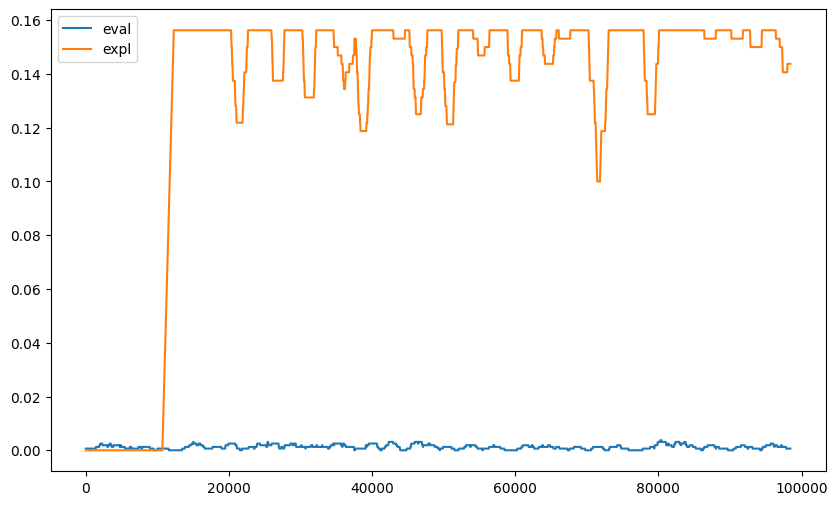

In [5]:
import matplotlib.pyplot as plt
import plotting


def smooth(r, w=50):
    filter = jnp.ones(w) / w
    return jnp.convolve(r, filter, mode="valid")


plt.figure(figsize=(10, 6))
r = smooth(results.eval_reward.mean(axis=-1))
plt.plot(results.eval_reward.shape[-1] * jnp.arange(1, 1 + len(r)), r, label="eval")
r = smooth(results.expl_reward.mean(axis=-1))
plt.plot(results.expl_reward.shape[-1] * jnp.arange(1, 1 + len(r)), r, label="expl")
plt.legend()
plt.show()

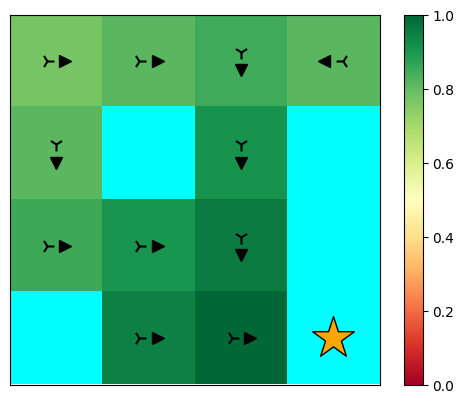

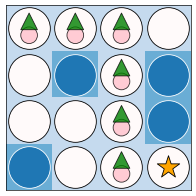

In [6]:
get_qval_fn = partial(sim_state.dql_state.qval_apply_fn, sim_state.dql_state.params_qnet)
plotting.plot_qvals(sim_state.env, get_qval_fn, hold=True, autoscale=False)

transitions = sims.greedy_rollout(sim_state.env, sim_state.dql_state, rng_key, steps=6)
plotting.render(sim_state.env, transitions.env_state)

In [7]:
rng_key = jax.random.PRNGKey(seed)
rng_init, rng_sim = jax.random.split(rng_key)
rng_sim = jax.random.split(rng_sim, n_rollouts)
%timeit jax.lax.scan(q_learning_step, sim_state, rng_sim)[1][0].block_until_ready()